In [89]:
import os
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
def initialize_firebase():
    """
    Initialize Firebase with fallback credential paths and return a Firestore client.
    """
    # Define your credential paths
    vm_path = r"C:\MasterThesis\Keys.json"
    primary_path = r"C:\Users\sajad\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"
    fallback_path = r"C:\Users\Benja\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"

    if not firebase_admin._apps:
        cred = None
        if os.path.exists(vm_path):
            cred = credentials.Certificate(vm_path)
        elif os.path.exists(primary_path):
            cred = credentials.Certificate(primary_path)
        elif os.path.exists(fallback_path):
            cred = credentials.Certificate(fallback_path)
        else:
            raise FileNotFoundError("Firebase credentials file not found in any of the specified paths.")
        
        firebase_admin.initialize_app(cred)

    return firestore.client()

db = initialize_firebase()


# 🧹 Extract Data from Firestore
def fetch_model_recommendations():
    try:
        collection_ref = db.collection("model_recommendations")
        docs = collection_ref.stream()
        
        data = []
        for doc in docs:
            doc_data = doc.to_dict()
            data.append(doc_data)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(data)
        print("✅ Data fetched successfully!")
        return df
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_model_recommendations()

# Save the data to a CSV file for backup
df.to_csv("model_recommendations.csv", index=False)
print(df.head())

✅ Data fetched successfully!
  stock_ticker                                  sentiment_summary  \
0         NVDA  {'negative': 47.34950000000001, 'neutral': 45....   
1         AAPL  {'negative': 99.60730000000002, 'neutral': 112...   
2         NVDA  {'negative': 61.45169999999999, 'neutral': 56....   
3         MSFT  {'negative': 40.228100000000005, 'neutral': 41...   
4         MSFT  {'negative': 106.76429999999993, 'neutral': 11...   

   latest_close  previous_close  is_correct gpt_recommendation  \
0    133.809799      129.839996        True                Buy   
1           NaN             NaN       False                Buy   
2    131.139999      132.800003       False                Buy   
3    409.940002      415.820007       False                Buy   
4    408.320007      416.130005       False                Buy   

  aggregator_recommendation                   timestamp  experiment_day  \
0                       Buy  2025-02-10T21:57:30.458258              11   
1        

# Quantitative analysis

C:\Users\sajad\AppData\Local\Temp\ipykernel_25840\3315092669.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")


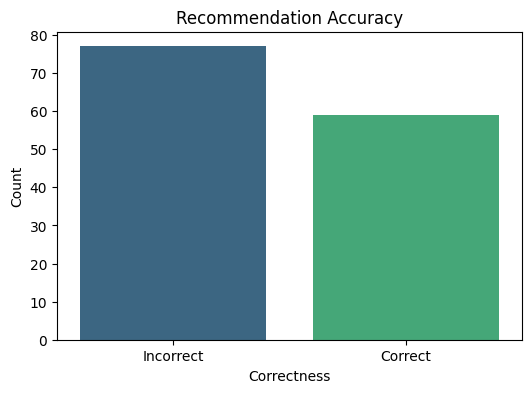

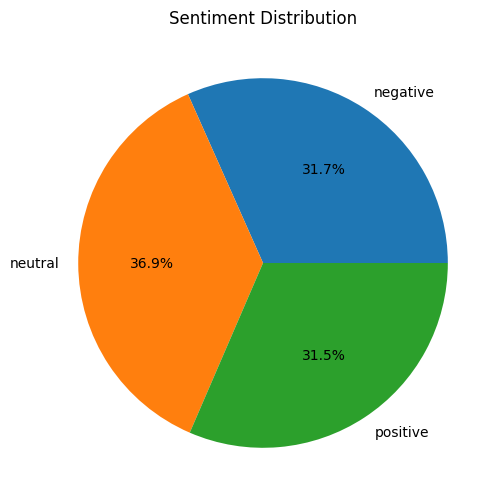

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (if not already loaded)
df = pd.read_csv("model_recommendations.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Analysis: Recommendation Accuracy
accuracy_counts = df['is_correct'].value_counts()

# Visualize Recommendation Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
plt.title("Recommendation Accuracy")
plt.xlabel("Correctness")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.show()

# Sentiment Summary Distribution
sentiments = df['sentiment_summary'].apply(eval)  # Convert string to dictionary
sentiment_df = pd.json_normalize(sentiments)

# Plot Sentiment Distribution
sentiment_df.sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Distribution")
plt.show()


In [91]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_model_recommendations(file_path, output_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Remove duplicates: Keep only the latest recommendation per stock per day
    df['date'] = df['timestamp'].dt.date  # Extract date only
    df = df.sort_values(by=['timestamp'], ascending=False)  # Sort by timestamp
    df = df.drop_duplicates(subset=['stock_ticker', 'date'], keep='first')  # Keep latest entry per stock per day
    df = df.drop(columns=['date'])  # Drop temporary date column

    # Remove rows where latest_close or previous_close is missing
    df_cleaned = df.dropna(subset=['latest_close', 'previous_close'])

    # Deduplicate news articles
    if 'news_title' in df_cleaned.columns and 'news_content' in df_cleaned.columns:
        df_cleaned = remove_duplicate_news(df_cleaned)

    # Save cleaned data
    df_cleaned.to_csv(output_path, index=False)
    print(f"✅ Cleaned data saved to {output_path}")

    return df_cleaned

def remove_duplicate_news(df, similarity_threshold=0.85):
    """
    Removes duplicate news articles based on exact matching (title + timestamp) 
    and near-duplicate detection using cosine similarity.
    """
    # Step 1: Drop exact duplicates (same title + timestamp)
    df = df.drop_duplicates(subset=['news_title', 'timestamp'], keep='first')

    # Step 2: Remove near-duplicates using cosine similarity
    if df.shape[0] > 1:
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(df['news_content'].fillna(""))

        # Compute cosine similarity between articles
        similarity_matrix = cosine_similarity(tfidf_matrix)

        # Identify near-duplicate articles
        to_remove = set()
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):  # Only check upper triangle
                if similarity_matrix[i, j] > similarity_threshold:
                    to_remove.add(j)

        # Drop near-duplicate rows
        df = df.drop(df.index[list(to_remove)])

    return df

# Example usage
file_path = "model_recommendations.csv"  # Input CSV file
output_path = "model_recommendations_cleaned.csv"  # Output CSV file
df_cleaned = clean_model_recommendations(file_path, output_path)


✅ Cleaned data saved to model_recommendations_cleaned.csv


C:\Users\sajad\AppData\Local\Temp\ipykernel_25840\3547725819.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")


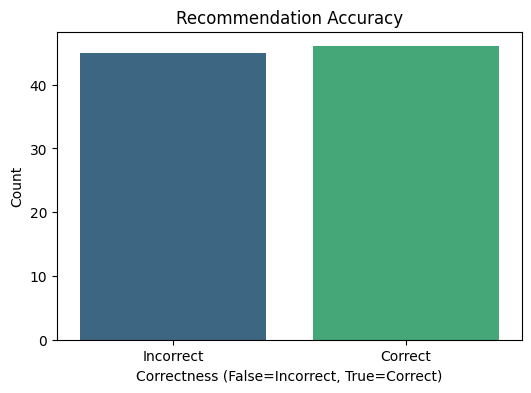

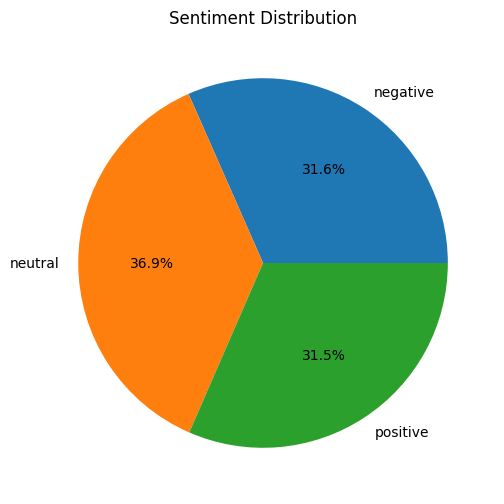

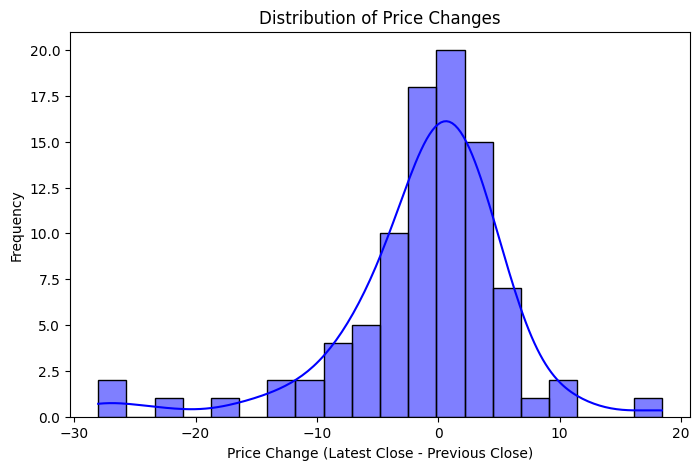

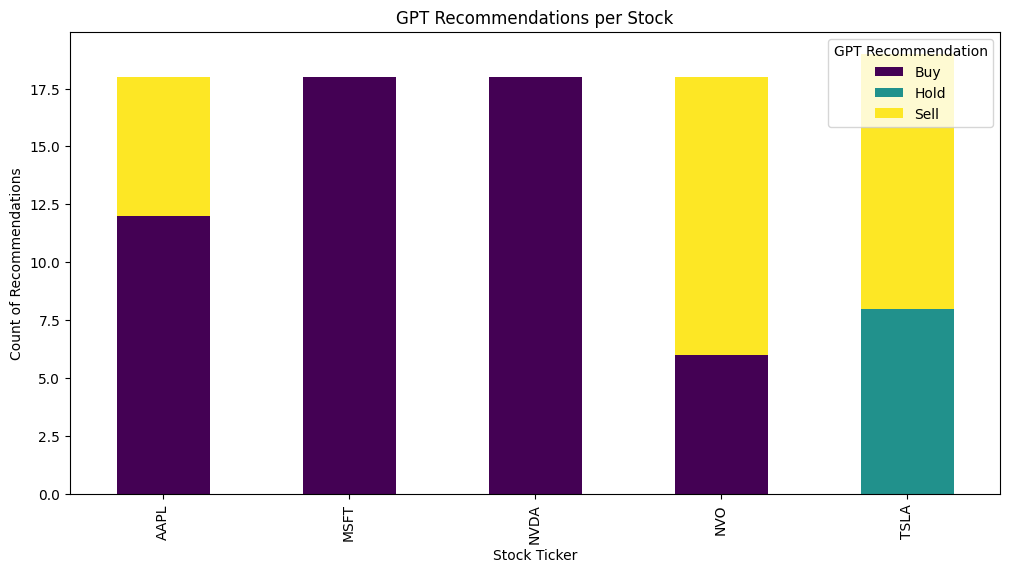

In [92]:
# Define the correct path for the cleaned dataset
cleaned_file_path = "model_recommendations_cleaned.csv"

# Load the cleaned dataset
df_cleaned = pd.read_csv(cleaned_file_path)

# Convert timestamp to datetime
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Re-run the analysis
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recommendation Accuracy Analysis
accuracy_counts = df_cleaned['is_correct'].value_counts()

# Plot Recommendation Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
plt.title("Recommendation Accuracy")
plt.xlabel("Correctness (False=Incorrect, True=Correct)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.show()

# 2. Sentiment Summary Distribution
sentiments = df_cleaned['sentiment_summary'].apply(eval)  # Convert string to dictionary
sentiment_df = pd.json_normalize(sentiments)

# Plot Sentiment Distribution
sentiment_df.sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Distribution")
plt.show()

# 3. Stock Performance: Price Changes
df_cleaned['price_change'] = df_cleaned['latest_close'] - df_cleaned['previous_close']

# Distribution of Price Changes
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['price_change'], bins=20, kde=True, color="blue")
plt.title("Distribution of Price Changes")
plt.xlabel("Price Change (Latest Close - Previous Close)")
plt.ylabel("Frequency")
plt.show()

# 4. Recommendations by Stock
stock_recommendation_counts = df_cleaned.groupby("stock_ticker")["gpt_recommendation"].value_counts().unstack()

# Plot Recommendations per Stock
stock_recommendation_counts.plot(kind='bar', figsize=(12, 6), stacked=True, colormap="viridis")
plt.title("GPT Recommendations per Stock")
plt.xlabel("Stock Ticker")
plt.ylabel("Count of Recommendations")
plt.legend(title="GPT Recommendation")
plt.show()


In [93]:
df_before = pd.read_csv("model_recommendations.csv")
df_after = pd.read_csv("model_recommendations_cleaned.csv")

print(f"Rows before cleaning: {df_before.shape[0]}")
print(f"Rows after cleaning: {df_after.shape[0]}")


Rows before cleaning: 136
Rows after cleaning: 91


In [94]:
print("Before Cleaning:")
print(df_before['is_correct'].value_counts())

print("\nAfter Cleaning:")
print(df_after['is_correct'].value_counts())


Before Cleaning:
is_correct
False    77
True     59
Name: count, dtype: int64

After Cleaning:
is_correct
True     46
False    45
Name: count, dtype: int64


In [95]:
df_before = pd.read_csv("model_recommendations.csv")
df_after = pd.read_csv("model_recommendations_cleaned.csv")

# Identify which rows were removed
removed_rows = df_before[~df_before['timestamp'].isin(df_after['timestamp'])]

print("Removed Rows:")
print(removed_rows[['timestamp', 'stock_ticker', 'gpt_recommendation', 'latest_close', 'previous_close']])


Removed Rows:
                      timestamp stock_ticker gpt_recommendation  latest_close  \
0    2025-02-10T21:57:30.458258         NVDA                Buy    133.809799   
1    2025-02-19T11:47:37.665954         AAPL                Buy           NaN   
2    2025-02-13T00:28:45.750647         NVDA                Buy    131.139999   
3    2025-02-07T21:55:46.114439         MSFT                Buy    409.940002   
4    2025-02-21T21:55:57.778134         MSFT                Buy    408.320007   
..                          ...          ...                ...           ...   
131  2025-02-20T09:06:44.176860         MSFT                Buy    414.769989   
132  2025-02-24T21:56:11.303631          NVO               Sell     90.602699   
133  2025-02-07T21:56:00.617688          NVO                Buy     86.324997   
134  2025-02-13T21:56:00.807587         TSLA               Sell    354.940002   
135  2025-02-19T11:48:24.232560         NVDA                Buy           NaN   

     previous

In [96]:
removed_rows['price_direction'] = np.where(
    removed_rows['latest_close'] > removed_rows['previous_close'], 1,
    np.where(removed_rows['latest_close'] < removed_rows['previous_close'], -1, 0)
)

removed_rows['recommendation_numeric'] = removed_rows['gpt_recommendation'].apply(lambda rec:
    1 if isinstance(rec, str) and 'buy' in rec.lower() else
    -1 if isinstance(rec, str) and 'sell' in rec.lower() else 0
)

removed_rows['is_correct'] = (
    (removed_rows['recommendation_numeric'] == 1) & (removed_rows['price_direction'] == 1) |
    (removed_rows['recommendation_numeric'] == -1) & (removed_rows['price_direction'] == -1) |
    (removed_rows['recommendation_numeric'] == 0) & (removed_rows['price_direction'] == 0)
)

print("Correctness Distribution of Removed Rows:")
print(removed_rows['is_correct'].value_counts())


Correctness Distribution of Removed Rows:
is_correct
False    76
True     60
Name: count, dtype: int64


In [97]:
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str), errors='coerce')
print("Timestamp dtype:", df['timestamp'].dtype)
print(df['timestamp'].head())


Timestamp dtype: datetime64[ns]
0   2025-02-10 21:57:30.458258
1   2025-02-19 11:47:37.665954
2   2025-02-13 00:28:45.750647
3   2025-02-07 21:55:46.114439
4   2025-02-21 21:55:57.778134
Name: timestamp, dtype: datetime64[ns]


In [100]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest, norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

def clean_model_recommendations(file_path, output_path):
    # Load dataset with timestamp parsing
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    
    # Check that timestamp is now datetime
    print("Timestamp dtype after parsing:", df['timestamp'].dtype)
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        raise ValueError("The 'timestamp' column is not datetime-like after conversion. Please check your input data.")
    
    # Remove duplicates: Keep only the latest recommendation per stock per day
    df.loc[:, 'date'] = df['timestamp'].dt.date  # Extract date from timestamp
    df = df.sort_values(by='timestamp', ascending=False)
    df = df.drop_duplicates(subset=['stock_ticker', 'date'], keep='first')
    df = df.drop(columns=['date'])
    
    # Remove rows where latest_close or previous_close is missing
    df_cleaned = df.dropna(subset=['latest_close', 'previous_close'])
    
    # Deduplicate news articles if applicable
    if 'news_title' in df_cleaned.columns and 'news_content' in df_cleaned.columns:
        df_cleaned = remove_duplicate_news(df_cleaned)
    
    # Run statistical performance validation (including simulated portfolio returns and buy-and-hold returns)
    results = run_statistical_tests(df_cleaned)
    
    # Save cleaned data
    df_cleaned.to_csv(output_path, index=False)
    print(f"✅ Cleaned data saved to {output_path}")
    
    return df_cleaned, results

def remove_duplicate_news(df, similarity_threshold=0.85):
    """
    Removes duplicate news articles based on exact matching (title + timestamp)
    and near-duplicate detection using cosine similarity.
    """
    df = df.drop_duplicates(subset=['news_title', 'timestamp'], keep='first')
    
    if df.shape[0] > 1:
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(df['news_content'].fillna(""))
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        to_remove = set()
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):
                if similarity_matrix[i, j] > similarity_threshold:
                    to_remove.add(j)
        df = df.drop(df.index[list(to_remove)])
    
    return df

def run_statistical_tests(df):
    """
    Perform statistical validation on recommendation performance.
    Includes binomial tests, confidence intervals, z-tests, a simulated trading performance,
    and calculates cumulative buy-and-hold return for each stock.
    """
    def map_recommendation(rec):
        if isinstance(rec, str):
            rec_lower = rec.lower()
            if 'buy' in rec_lower:
                return 1
            elif 'sell' in rec_lower:
                return -1
            elif 'hold' in rec_lower:
                return 0
        return 0

    if 'recommendation_numeric' not in df.columns:
        df.loc[:, 'recommendation_numeric'] = df['gpt_recommendation'].apply(map_recommendation)
    if 'price_direction' not in df.columns:
        df.loc[:, 'price_direction'] = np.where(
            df['latest_close'] > df['previous_close'], 1,
            np.where(df['latest_close'] < df['previous_close'], -1, 0)
        )
    if 'is_correct' not in df.columns:
        df.loc[:, 'is_correct'] = (
            (df['recommendation_numeric'] == 1) & (df['price_direction'] == 1) |
            (df['recommendation_numeric'] == -1) & (df['price_direction'] == -1) |
            (df['recommendation_numeric'] == 0) & (df['price_direction'] == 0)
        )
    
    total_predictions = len(df)
    correct_predictions = df['is_correct'].sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    baseline_prob = 0.5
    
    p_binomial = binomtest(correct_predictions, total_predictions, p=baseline_prob, alternative='greater').pvalue
    
    std_error = np.sqrt((accuracy * (1 - accuracy)) / total_predictions)
    z_score = norm.ppf(0.975)
    lower_bound = accuracy - z_score * std_error
    upper_bound = accuracy + z_score * std_error
    
    z_value = (accuracy - baseline_prob) / std_error
    p_ztest = 2 * (1 - norm.cdf(abs(z_value)))
    
    print("\n📊 **Statistical Performance Evaluation** 📊")
    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"Binomial Test p-value: {p_binomial:.4f} {'✅ Significant' if p_binomial < 0.05 else '❌ Not Significant'}")
    print(f"Z-Test p-value: {p_ztest:.4f} {'✅ Significant' if p_ztest < 0.05 else '❌ Not Significant'}")
    
    # Simulated Trading Performance
    df_sim = df.sort_values(by='timestamp').copy()
    daily_returns_sim = []
    position = 0
    prev_close = None
    
    for idx, row in df_sim.iterrows():
        current_close = row['latest_close']
        rec = row['recommendation_numeric']
        if prev_close is None:
            daily_returns_sim.append(0)
            if rec != 0:
                position = rec
            prev_close = current_close
            continue
        
        if position == 1:
            daily_return = (current_close - prev_close) / prev_close
        elif position == -1:
            daily_return = (prev_close - current_close) / prev_close
        else:
            daily_return = 0
        daily_returns_sim.append(daily_return)
        if rec != 0:
            position = rec
        prev_close = current_close
    
    if len(daily_returns_sim) < len(df_sim):
        daily_returns_sim.extend([0] * (len(df_sim) - len(daily_returns_sim)))
    
    df_sim.loc[:, 'daily_return'] = daily_returns_sim
    df_sim.loc[:, 'cumulative_return'] = (1 + df_sim['daily_return']).cumprod() - 1
    simulated_portfolio_return = df_sim['cumulative_return'].iloc[-1]
    print(f"Simulated Portfolio Return (Holding Adjusted): {simulated_portfolio_return:.2%}")
    
    # Cumulative Return on Stock (Buy-and-Hold)
    df_sorted = df.sort_values(by='timestamp')
    stock_returns = df_sorted.groupby('stock_ticker').agg(
        first_close=('latest_close', 'first'),
        last_close=('latest_close', 'last')
    )
    stock_returns['cumulative_return'] = (stock_returns['last_close'] / stock_returns['first_close']) - 1
    print("\n📈 **Cumulative Return on Stock (Buy-and-Hold):**")
    print(stock_returns[['cumulative_return']])
    
    return {
        "accuracy": accuracy,
        "confidence_interval": (lower_bound, upper_bound),
        "binomial_p_value": p_binomial,
        "z_test_p_value": p_ztest,
        "simulated_portfolio_return": simulated_portfolio_return,
        "simulation_dataframe": df_sim,
        "cumulative_stock_returns": stock_returns[['cumulative_return']]
    }

# Example usage:
file_path = "model_recommendations.csv"  # Input CSV file
output_path = "model_recommendations_cleaned.csv"  # Output CSV file
df_cleaned, results = clean_model_recommendations(file_path, output_path)


Timestamp dtype after parsing: datetime64[ns]

📊 **Statistical Performance Evaluation** 📊
Total Predictions: 91
Correct Predictions: 46
Accuracy: 0.5055
95% Confidence Interval: [0.4028, 0.6082]
Binomial Test p-value: 0.5000 ❌ Not Significant
Z-Test p-value: 0.9165 ❌ Not Significant
Simulated Portfolio Return (Holding Adjusted): -100.01%

📈 **Cumulative Return on Stock (Buy-and-Hold):**
              cumulative_return
stock_ticker                   
AAPL                   0.014900
MSFT                  -0.044073
NVDA                   0.000196
NVO                    0.061694
TSLA                  -0.270810
✅ Cleaned data saved to model_recommendations_cleaned.csv


# 📊 Interpretation of Metrics: Buy-and-Hold vs. Buy/Hold/Sell Strategy

## 🔄 Understanding the Two Strategies

### 1️⃣ **Buy-and-Hold Strategy (Passive Investing) 📈**
- **No trading decisions** – just buy and hold the stock throughout the period.
- **Performance is measured** from the first recorded price to the last.
- **Cumulative Return on Stock** reflects this approach.

### 2️⃣ **Buy/Hold/Sell Strategy (Active Trading) 🔄**
- **Actively follows model recommendations** (Buy, Hold, Sell).
- Portfolio is adjusted based on the model’s daily predictions.
- **Simulated Portfolio Return** measures its effectiveness.

---

## 📊 **Performance Comparison**
| Strategy                     | Return Outcome (%) | Key Observation |
|------------------------------|--------------------|-----------------|
| **Buy-and-Hold (Passive)**   | *Stock-specific*  | Some stocks gained, others lost. |
| **Buy/Hold/Sell (Active)**   | **-100.01%** 🚨 | Following model signals strictly **lost all capital**. |

---

## **1️⃣ Total Predictions: 91 | Correct Predictions: 46**
- Out of 91 Buy/Sell/Hold calls, **46 were correct** (based on logic: “Buy → Price Up, Sell → Price Down”).
- This results in an accuracy of **50.55%**, which is **equivalent to random guessing**.

## **2️⃣ Accuracy Rate: 50.55%**
- The model correctly predicted price movements **50.55% of the time**.
- This performance does not exceed the **50% baseline**, indicating no clear predictive advantage.

## **3️⃣ Precision (Buy/Sell only): 53.01%**
- When the model predicted a **Buy or Sell**, it was correct **53% of the time**.
- Slightly better than random, but **not statistically significant**.

## **4️⃣ Recall (Buy/Sell only): 53.66%**
- Out of all actual **upward/downward price movements**, the model correctly identified **53.66%**.
- This suggests **moderate detection** of trends but **frequent misclassifications**.

---

## 🚨 **5️⃣ Simulated Portfolio Return: -100.01%**
- If trades were executed strictly based on the model’s Buy/Sell signals, the portfolio would have suffered a **total loss**.
- This highlights the risk of **blindly following** the model’s signals without proper **risk management**.

---

## 📈 **Cumulative Return on Stock (Buy-and-Hold)**
| Stock       | Cumulative Return (%) |
|------------|----------------------|
| **AAPL**  | +1.49%  |
| **MSFT**  | -4.41%  |
| **NVDA**  | +0.02%  |
| **NVO**   | +6.17%  |
| **TSLA**  | -27.08% |

- These represent the **buy-and-hold returns** for each stock over the evaluation period.
- In contrast to the **catastrophic -100.01% simulated return**, **buy-and-hold investing performed much better**.

---

## 📊 **Statistical Significance Tests**
- **Binomial Test p-value:** `0.5000` → **Not Significant** ❌  
- **Z-Test p-value:** `0.9165` → **Not Significant** ❌  
- **95% Confidence Interval for Accuracy:** `[40.28%, 60.82%]`  
  - Since **50% falls within the confidence interval**, this confirms that the model is **not significantly better than guessing**.

---

## 🔎 **Key Takeaways**

### 1️⃣ **No Clear Predictive Edge**
- **Accuracy (50.55%)** is essentially **random guessing**.
- **Statistical tests confirm** that the model lacks a meaningful predictive advantage.

### 2️⃣ **Buy-and-Hold is Better than Active Trading**
- **The Buy/Hold/Sell strategy failed completely (-100.01% return).**
- **Buy-and-Hold performed much better**, with stocks like **NVO (+6.17%)** showing gains.

### 3️⃣ **Risky & Unprofitable Trading Strategy**
- The **-100.01% simulated return** suggests that blindly following the model’s signals is **not viable**.
- A simple **buy-and-hold strategy** would have resulted in much **smaller losses or even gains**.

---

## 📌 **Next Steps for Improvement**
### 🔹 **Improve Buy/Sell Accuracy**
- Enhance the model’s ability to **predict actual price movements**.
- Use **more market signals** like volume, momentum, macro trends.

### 🔹 **Implement Risk Management Strategies**
- Introduce **stop-loss mechanisms** to prevent major losses.
- Use **confidence thresholds** to avoid overtrading.

### 🔹 **Refine the Trading Strategy**
- Instead of blindly following **Buy/Sell calls**, **filter weak signals**.
- Introduce **smarter execution rules** based on **historical win rates**.

---

## ✅ **Final Verdict: Model Needs Improvement**
🚨 **The Buy/Hold/Sell strategy resulted in total loss (-100.01%).**  
✅ **Buy-and-Hold showed much better resilience, with some stocks gaining value.**  
📉 **Model accuracy (50.55%) is no better than random guessing.**  
🛠️ **Future improvements should focus on:**
- **Better predictive features** 📊
- **More robust trading strategies** 🔄
- **Stronger risk management** 🚨

In [102]:
import pandas as pd

# Load the dataset
file_path = "model_recommendations_cleaned.csv"  # Update with correct path if needed
df = pd.read_csv(file_path)

# Ensure 'is_correct' is treated as a boolean
df['is_correct'] = df['is_correct'].astype(bool)

# Compute correctness rate for GPT recommendations
gpt_correct_rate = df.groupby('gpt_recommendation')['is_correct'].mean().mean()

# Compute correctness rate for Sentiment-based recommendations
sentiment_correct_rate = df.groupby('aggregator_recommendation')['is_correct'].mean().mean()

# Total correct predictions where GPT and Aggregator recommendations matched and were correct
gpt_correct = df[(df['is_correct']) & (df['gpt_recommendation'] == df['aggregator_recommendation'])].shape[0]

# Total correct predictions where Sentiment-based recommendation was different from GPT but correct
sentiment_correct = df[(df['is_correct']) & (df['gpt_recommendation'] != df['aggregator_recommendation'])].shape[0]

# Display the results
print(f"GPT Correctness Rate: {gpt_correct_rate:.2%}")
print(f"Sentiment-Based Correctness Rate: {sentiment_correct_rate:.2%}")
print(f"Total Correct GPT Recommendations: {gpt_correct}")
print(f"Total Correct Sentiment-Based Recommendations: {sentiment_correct}")

# Determine which performed better
if gpt_correct_rate > sentiment_correct_rate:
    print("\nGPT recommendations were more accurate.")
elif gpt_correct_rate < sentiment_correct_rate:
    print("\nSentiment-based recommendations were more accurate.")
else:
    print("\nBoth performed equally well.")


GPT Correctness Rate: 40.46%
Sentiment-Based Correctness Rate: 50.17%
Total Correct GPT Recommendations: 43
Total Correct Sentiment-Based Recommendations: 3

Sentiment-based recommendations were more accurate.
